In [ ]:
from keras.layers import *
from __future__ import division
from __future__ import print_function
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Dropout, LSTM
from keras.optimizers import sgd
import os
import random
from os.path import isfile
from collections import deque
from keras import utils

from gym.core import Wrapper
class RewardForPassingGates(Wrapper):
    """Skiing wrapper that rewards player +1 for passing gates only."""
    def _reset(self):
        """On game reset, remember the hash of initial score"""
        s = self.env.reset()
        self.prev_score_hash = hash(s[31:38,67:81].tobytes()) #hash of the image chunk with scoreboard
        self.actions_count = 0
        return s
    def _step(self,action):
        """on each step, if score has changed, give +1 reward, else +0"""
        s,_,done,info = self.env.step(action)
        new_score_hash = hash(s[31:38,67:81].tobytes()) #hash of the same image chunk

        #reward = +1 if we have just crossed the gate, else 0
        r = int(new_score_hash != self.prev_score_hash)
        
        if r != 0:
            self.actions_count = 0
            print("YAA")
        
        self.actions_count += 1
        if self.actions_count == 300:
            r = -0.03
            self.actions_count = 0
            print("NEYA")

        #remember new score
        self.prev_score_hash = new_score_hash
        return s,r,done,info

NUM_ACTIONS = 3
NUM_STATES = 3
MAX_REPLAY_STATES = 10
BATCH_SIZE = 10
NUM_GAMES_TRAIN = 5
JUMP_FPS = 5
WEIGHT_FILE = 'weights.h5'


replay = []

gamma = 0.8
epsilon = 1

env = gym.make("Skiing-v0")

#env = RewardForPassingGates(env)



layers = [
    #Reshape((1, 250, 160, 3), input_shape=(250, 160, 3)),
    BatchNormalization(input_shape=(150, 144, 9)),
    Convolution2D(4, 3, 3, border_mode='valid', init="uniform", activation="relu"),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    Convolution2D(8, 3, 3, border_mode='valid', init="uniform", activation="relu"),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    Convolution2D(16, 3, 3, init="uniform", activation="relu"),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    Convolution2D(32, 3, 3, activation="relu", init="uniform"),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    BatchNormalization(),
    #Flatten(),
    Reshape((36, 32)),
    LSTM(32),
    Dense(100, activation='relu', init="uniform"),
    Dropout(0.5),
    Dense(output_dim=3, activation='softmax', init="uniform")
]


def t(st):
    #print(len(st))
    imgs = []
    for img in st:
        img = img[50:-50, 8:-8]
        imgs.append(img)
        
    imgs = np.concatenate(imgs, axis=2)
    #print(imgs.shape)
    imgs = imgs.astype("float16")
    return imgs.reshape(150, 144, 9) / 255.

model = Sequential(layers)
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])
#model.load_weights(WEIGHT_FILE)

NUM_ACTIONS
prb = 0.2
gamma = 0.8
epsilon = 80

actions_number = 1
last_action = 0
last_action_count = 0

st = env.reset()


for number_game in range(10):
    new_state = env.reset()
    x_window = []
    x_window.append(new_state)
    
    new_state, reward, done, info = env.step(0)
    x_window.append(new_state)
    
    new_state, reward, done, info = env.step(0)
    x_window.append(new_state)

    reward_game = 0
    done = False
    loss = 0
    index_train_per_game = 0
    position = 0
    print( '[+] Starting Game ' + str(number_game))
    while not done:
        env.render()
        index_train_per_game += 1
        if random.randint(0, 100) < epsilon:
            action = np.random.randint(NUM_ACTIONS)
        else:
            #print("Tyt", len(x_window))
            q = model.predict(t(x_window).reshape(1, 150, 144, 9))[0]
            action = np.argmax(q)


        old_state = x_window[:]
        if last_action_count == 20:
            while action == last_action:
                action = np.random.randint(NUM_ACTIONS)
        
    
        new_state, reward, done, info = env.step(action)
        x_window.append(new_state)
        x_window = x_window[1:]
        #print("x_window", len(x_window))

        if action == last_action:
            last_action_count += 1
        else:
            last_action_count = 1
            last_action = action
            
        for pos in range(20, 25):
            try:
                
                position = t(x_window)[0, :, :3][pos].tolist().index([0.83935546875, 0.36083984375, 0.36083984375])
            except Exception:
                position = 65
            
        #print(position)
        reward_game += reward
        replay.append([x_window[:], reward, action, done, old_state])


        if len(replay) > MAX_REPLAY_STATES:
            replay.pop(np.random.randint(MAX_REPLAY_STATES) + 1)

        #if JUMP_FPS != 1 and index_train_per_game % JUMP_FPS == 0:
            #continue


        len_mini_batch = min(len(replay), BATCH_SIZE)

        mini_batch = random.sample(replay, len_mini_batch)

        X_train = []
        Y_train = []

        if actions_number % 50 == 0:
            for index_rep in range(len_mini_batch):
                new_rep_state, reward_rep, action_rep, done_rep, old_rep_state = mini_batch[index_rep]
                #print("Tyt2", len(new_rep_state))
                temp = model.predict(t(new_rep_state).reshape(1, 150, 144, 9))
                #if index_rep % 10 == 0 and index_rep != 0:
                    #print(temp, "index = ", index_rep)

                #print("Tyt3", len(old_rep_state))
                old_q = model.predict(t(old_rep_state).reshape(1, 150, 144, 9))[0]
                new_q = temp[0]
                update_target = np.copy(old_q)
                if done_rep:
                    update_target[action_rep] = -1
                else:
                    update_target[action_rep] = reward_rep + (gamma * np.max(new_q))
                X_train.append(t(old_rep_state))
                Y_train.append(utils.np_utils.to_categorical( [np.argmax(update_target)], 3)[0])
                #Y_train.append(update_target)

            X_train = np.array(X_train)
            Y_train = np.array(Y_train)

            loss += np.array(model.train_on_batch(X_train, Y_train))
        
        actions_number += 1

        if reward_game > 200:
            break
    loss_print = (loss / index_train_per_game * JUMP_FPS).tolist()
    print ("[+] End Game {} | Reward {} | Epsilon {:.4f} | TrainPerGame {} | Loss [{:.4f}, {:.4f}] ".format(number_game, reward_game, epsilon, index_train_per_game, loss_print[0], loss_print[1]))
    #if epsilon >= 0.8:
    #  epsilon -= (1 / (NUM_GAMES_TRAIN))
    if isfile(WEIGHT_FILE):
        os.remove(WEIGHT_FILE)
    model.save_weights(WEIGHT_FILE)

[2017-01-19 03:59:23,700] Making new env: Skiing-v0


[+] Starting Game 0


In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_9 (BatchNorma (None, 150, 144, 9)   18          batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 148, 142, 4)   328         batchnormalization_9[0][0]       
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 73, 70, 4)     0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 71, 68, 8)     296         maxpooling2d_13[0][0]            
___________________________________________________________________________________________

In [74]:
for index_rep in range(len_mini_batch):
    new_rep_state, reward_rep, action_rep, done_rep, old_rep_state = mini_batch[index_rep]
    #print("Tyt2", len(new_rep_state))
    temp = model.predict(t(new_rep_state).reshape(1, 150, 144, 9))
    #if index_rep % 10 == 0 and index_rep != 0:
        #print(temp, "index = ", index_rep)

    #print("Tyt3", len(old_rep_state))
    old_q = model.predict(t(old_rep_state).reshape(1, 150, 144, 9))[0]
    new_q = temp[0]
    update_target = np.copy(old_q)
    if done_rep:
        update_target[action_rep] = -1
    else:
        update_target[action_rep] = reward_rep + (gamma * np.max(new_q))
    X_train.append(t(old_rep_state))
    Y_train.append(update_target)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [81]:
Y_train[5]

array([  1.18641766e-19,   1.00000000e+00,  -4.19999981e+00], dtype=float32)

In [65]:
new_state, reward, done, info = env.step(2)
x_window.append(new_state)
x_window = x_window[1:]
model.predict(t(x_window).reshape(1, 150, 144, 9))[0]

array([  2.85441831e-19,   1.00000000e+00,   1.38476966e-17], dtype=float32)

In [29]:
q

array([  1.00000000e+00,   1.58483332e-16,   2.54468720e-11], dtype=float32)

In [11]:
np.concatenate(x_window, axis=2).shape

(250, 160, 9)

In [65]:
%matplotlib inline
import matplontlib.pyplot as plt

In [107]:
t(new_state)[20].tolist().index([0.83935546875, 0.36083984375, 0.36083984375])

(150, 144, 3)


69

In [105]:
t(new_state)[20].tolist()

(150, 144, 3)


[[0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.92529296875],
 [0.92529296875, 0.92529296875, 0.925292

(150, 144, 3)


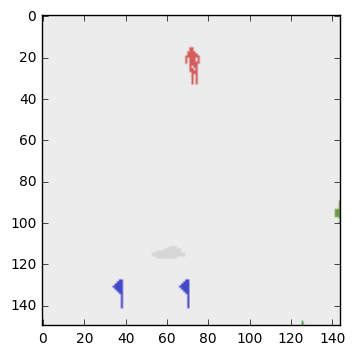

In [95]:
plt.imshow(t(new_state))

In [58]:
t(new_state)[50]

array([[ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.925

In [38]:
set(t(new_state).flatten())

{0.0,
 0.25879,
 0.28247,
 0.36084,
 0.396,
 0.4314,
 0.61182,
 0.61963,
 0.62744,
 0.75293,
 0.78418,
 0.81592,
 0.83936,
 0.92529}

In [40]:
t(new_state)[0]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.92529297],
       [ 0.92529297,  0.92529297,  0.925

In [32]:
set(new_state.flatten())

{0, 66, 72, 92, 101, 158, 160, 192, 200, 208, 214, 236}

In [34]:
new_state[5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

In [11]:
if random.random() < epsilon:
    action = np.random.randint(NUM_ACTIONS)

In [14]:
st.min()

0.0

In [41]:
model.predict(t(new_state))[0]

array([  7.24852782e-08,   9.91017699e-01,   9.01098147e-08], dtype=float32)

In [98]:
model.save('lunch')